In [1]:
!pip install gymnasium
!pip install stable_baselines3

In [2]:
import numpy as np
import bms_env
import matplotlib.pyplot as plt
import seaborn as sns

from utils import *


# Import the necessary libraries
from stable_baselines3 import DQN
from stable_baselines3.common.env_checker import check_env

In [3]:
bms = bms_env.BMSenv(num_cells= 5, k_tanh_params= [0.8, 2.5, 0.5, 1.5, 2], Q_cells = [2.35, 1., 0.5, 3, 1.75])
print(bms)

BMSenv(num_cells=5,
        k_tanh_params=[0.8 2.5 0.5 1.5 2. ],
        Q_cells=[2.35 1.   0.5  3.   1.75],
        MAX_VOLTAGE=4.2,
        MIN_VOLTAGE=2.2,
        INIT_SOC=0.9,
        I_CURRENT=0.22,
        TIMESTEP=0.001,
        w_reward=100.0,
        current_state=[4.19999 4.19999 4.19999 4.19999 4.19999],
        current_soc=[0.86866646 0.89996368 0.80463598 0.89802178 0.8997317 ])


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


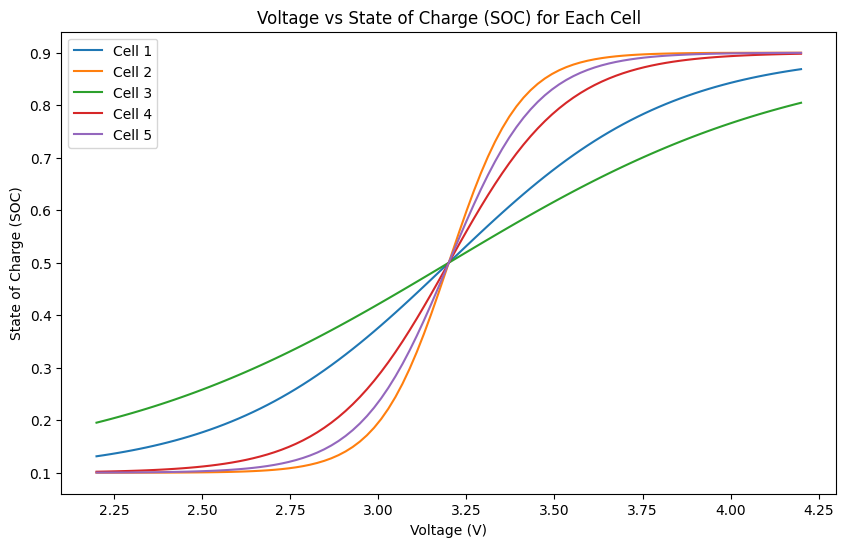

In [4]:
plot_voltage_vs_soc(bms)

In [5]:
T = 20_000

# Always disconected (All the batteries stay still)

In [6]:
bms.reset()
states_1 = [bms.state]
states_soc_1 = [bms.state_soc]
actions_1 = []
rewards_1 = []
dones_1 = [False]
actions_int_1 = []

while not dones_1[-1] and len(states_1) < T:
    action = 0
    actions_int_1.append(action)
    state, reward, done, _, _ = bms.step(action)
    states_1.append(state)
    states_soc_1.append(bms.state_soc)
    actions_1.append(bms.int_action_to_switch_action(action))
    rewards_1.append(reward)
    dones_1.append(done)

print(f"Sum of rewards: {np.sum(rewards_1)}")

Sum of rewards: -1999900


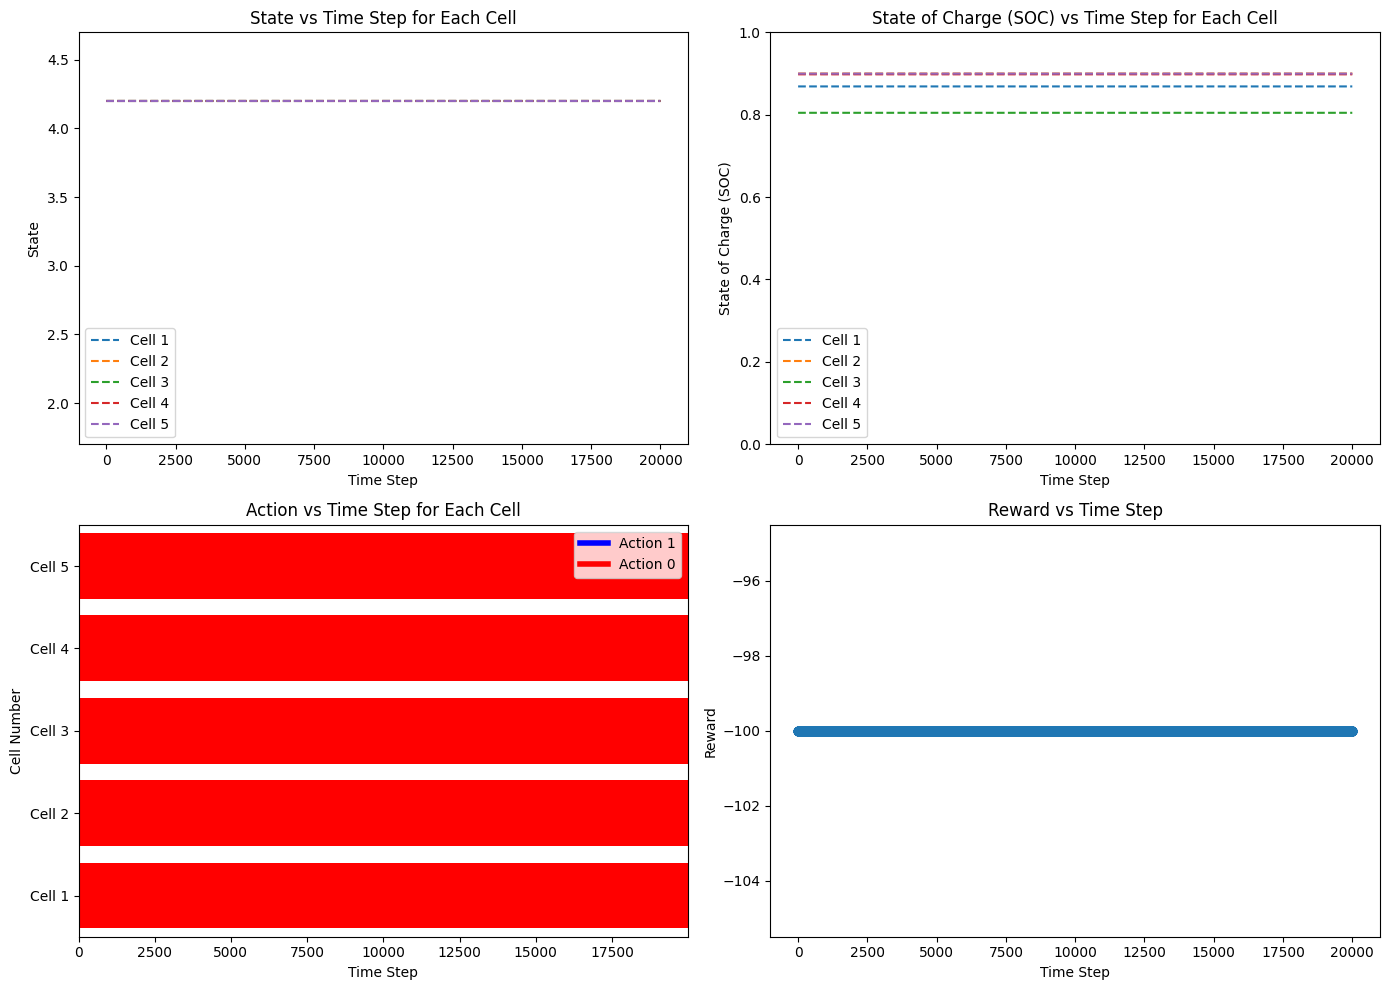

In [7]:
plot_bms_evolution(bms, states_1, states_soc_1, actions_1, rewards_1, dones_1, include_bad_rewards=True)

# Always connected (All the batteries Discharge)

In [8]:
bms.reset()
states_2 = [bms.state]
states_soc_2 = [bms.state_soc]
actions_2 = []
rewards_2 = []
dones_2 = [False]
actions_int_2 = []

while not dones_2[-1] and len(states_2) < T:
    action = bms.num_cells -1
    actions_int_2.append(action)
    state, reward, done, _, _ = bms.step(action)
    states_2.append(state)
    states_soc_2.append(bms.state_soc)
    actions_2.append(bms.int_action_to_switch_action(action))
    rewards_2.append(reward)
    dones_2.append(done)

print(f"Sum of rewards: {np.sum(rewards_2)}")

Sum of rewards: -80.02970364675124


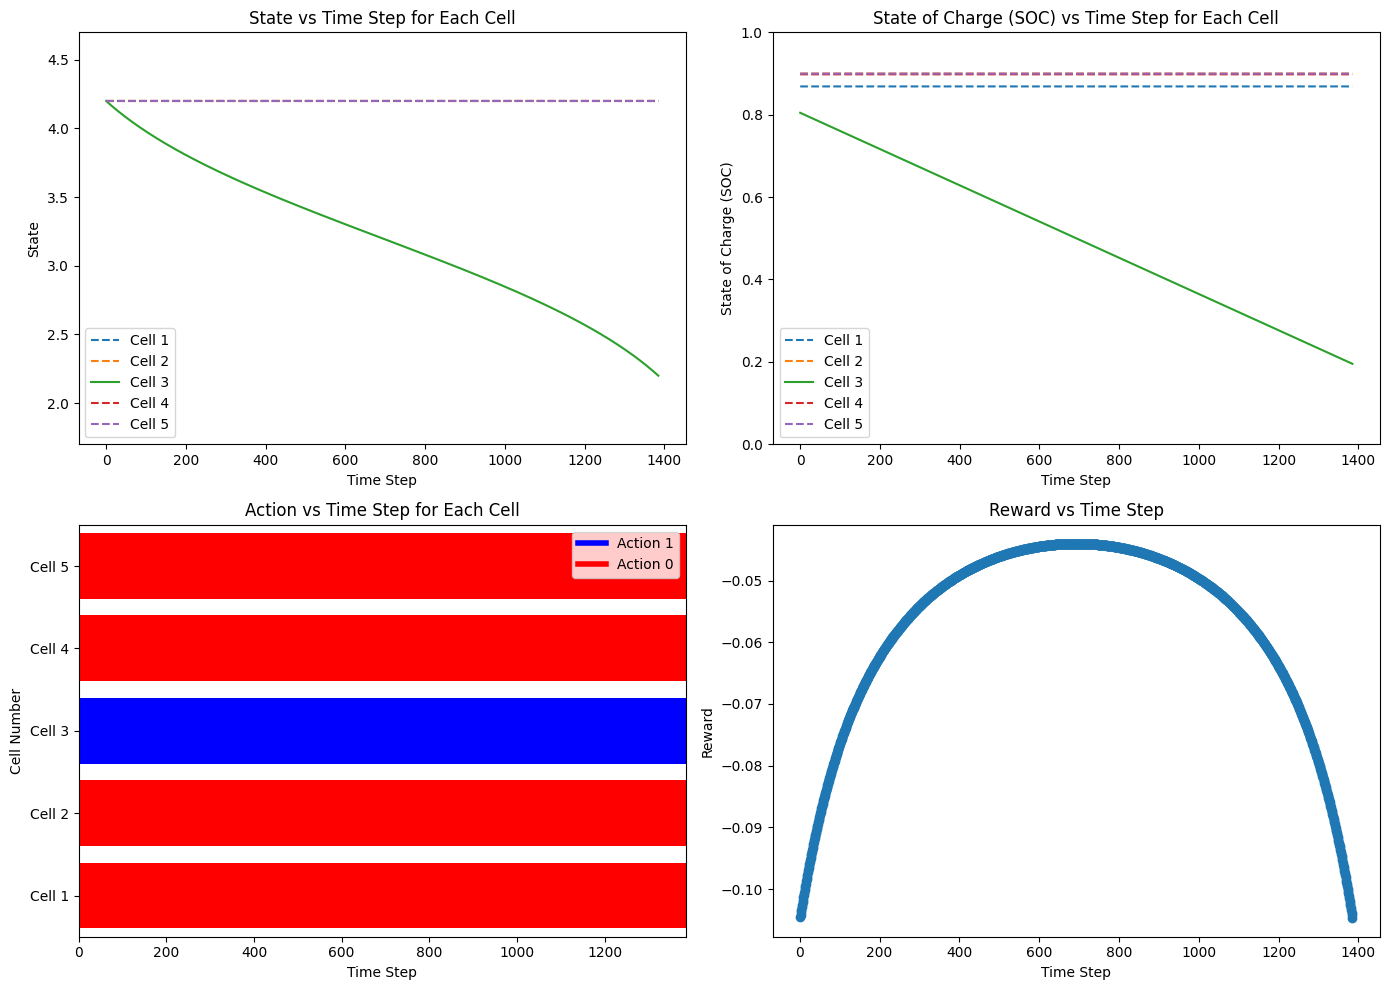

In [9]:
plot_bms_evolution(bms, states_2, states_soc_2, actions_2, rewards_2, dones_2)

# Random Controller

In [10]:
bms.reset()
states_5 = [bms.state]
states_soc_5 = [bms.state_soc]
actions_5 = []
rewards_5 = []
dones_5 = [False]
actions_int_5 = []

while not dones_5[-1] and len(states_5) < T:
    action = bms.action_space.sample()
    # while action == 0:
    #     action = bms.action_space.sample()
    actions_int_5.append(action)
    state, reward, done, _, _ = bms.step(action)
    states_5.append(state)
    states_soc_5.append(bms.state_soc)
    actions_5.append(bms.int_action_to_switch_action(action))
    rewards_5.append(reward)
    dones_5.append(done)

print(f"Sum of rewards: {np.sum(rewards_5)}")

Sum of rewards: -8851.513483969302


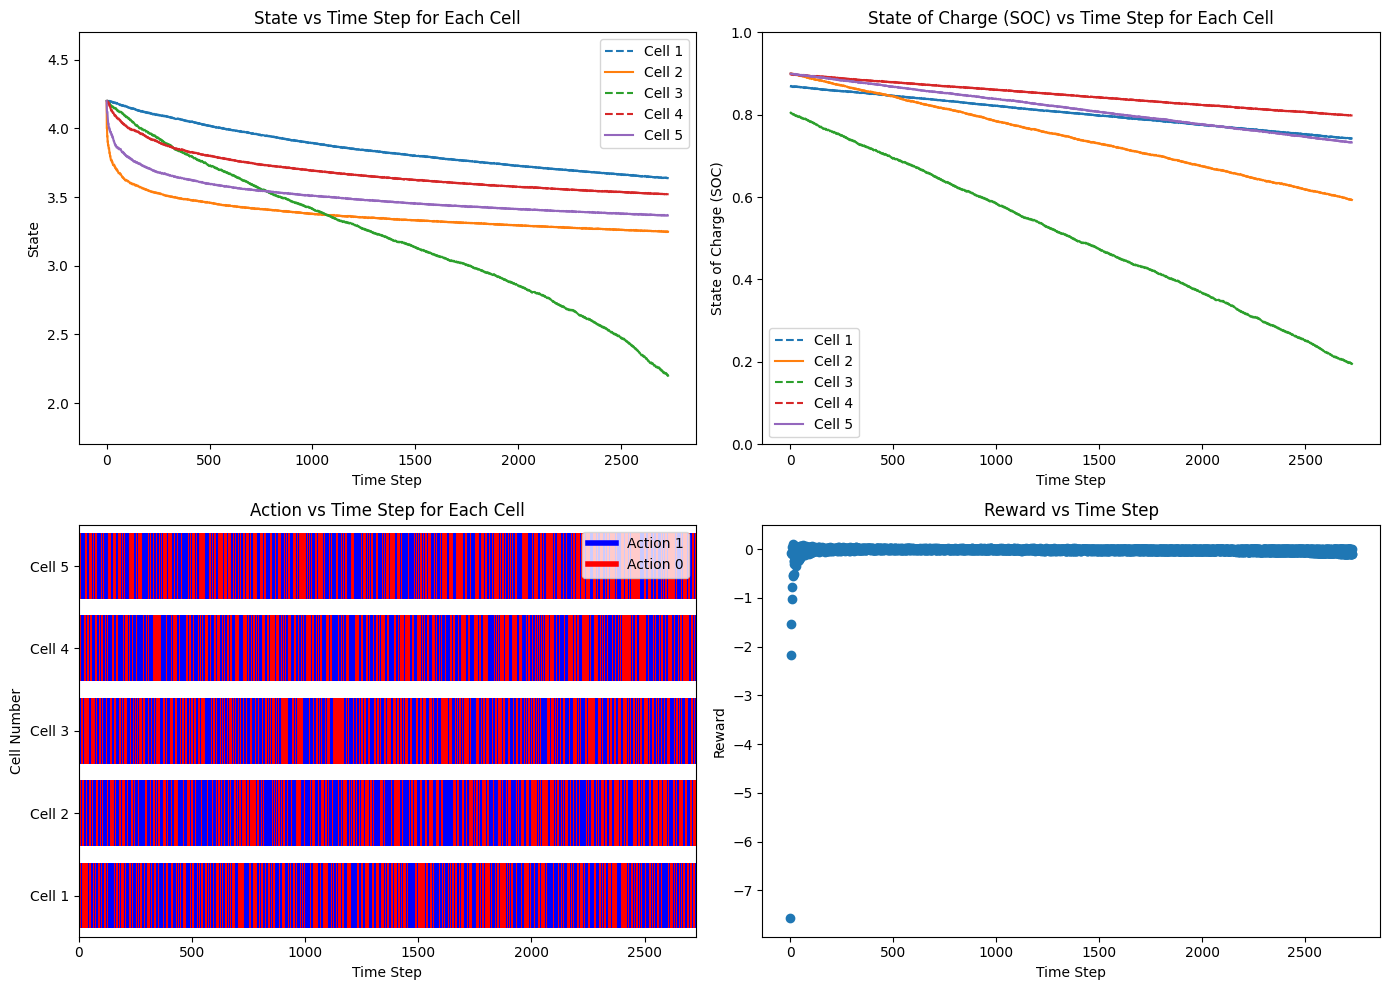

In [11]:
plot_bms_evolution(bms, states_5, states_soc_5, actions_5, rewards_5, dones_5)

(array([348., 215., 275., 272., 268., 244., 260., 268., 238., 340.]),
 array([ 0. ,  3.1,  6.2,  9.3, 12.4, 15.5, 18.6, 21.7, 24.8, 27.9, 31. ]),
 <BarContainer object of 10 artists>)

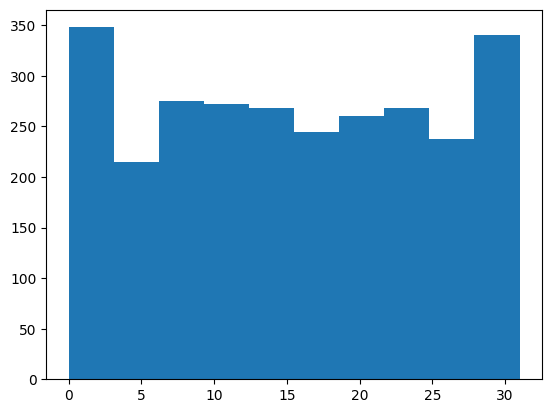

In [12]:
plt.hist(actions_int_5)

# TABULAR Q-Learning

In [13]:
bins = np.array([2.2, 2.5, 2.8, 3, 3.15, 3.30 , 3.40, 3.50 , 3.65, 3.80, 4.0 ,4.2])



In [14]:
bins

array([2.2 , 2.5 , 2.8 , 3.  , 3.15, 3.3 , 3.4 , 3.5 , 3.65, 3.8 , 4.  ,
       4.2 ])

In [15]:
print(bms.int_action_to_switch_action(0))
print(bms.int_action_to_switch_action(1))
print(bms.int_action_to_switch_action(2))
print(bms.int_action_to_switch_action(3))

[0 0 0 0 0]
[0 0 0 0 1]
[0 0 0 1 0]
[0 0 0 1 1]


In [16]:
state_count, action_count = (len(bins) - 1)**bms.num_cells, 2**bms.num_cells
state_count, action_count
Q = np.zeros((state_count, action_count))
Q[:, 0] = -100

bms.reset()
states_6= [bms.state]
states_soc_6 = [bms.state_soc]
actions_6 = []
rewards_6 = []
dones_6 = [False]
random_actions_6 = []
actions_int_6 = []
states_int_6 = [features_to_unique_integer(states_6[-1], bins)]

epsilon = 0.01
stepsize = 0.5
gamma = 0.99

while not dones_6[-1] and len(states_6) < 2*T:

    state_int  = features_to_unique_integer(states_6[-1], bins)

    if np.random.uniform(0, 1) < epsilon:
        random_actions_6.append(True)
        action = bms.action_space.sample()
        # while action == 0:
        #     action = bms.action_space.sample()
    else:
        random_actions_6.append(False)
        action = np.argmax(Q[state_int, :])


    actions_int_6.append(action)

    state, reward, done, _ , _= bms.step(action)
    states_6.append(state)
    states_soc_6.append(bms.state_soc)
    actions_6.append(bms.int_action_to_switch_action(action))
    rewards_6.append(reward)
    dones_6.append(done)


    if not done:
        next_state_int = features_to_unique_integer(state, bins)
        states_int_6.append(next_state_int)
        Q[state_int, action] = Q[state_int, action] + stepsize * (reward + gamma * np.max(Q[next_state_int, :]) - Q[state_int, action])


print(f"Sum of rewards: {np.sum(rewards_6)}")

Sum of rewards: -665.4847954475148


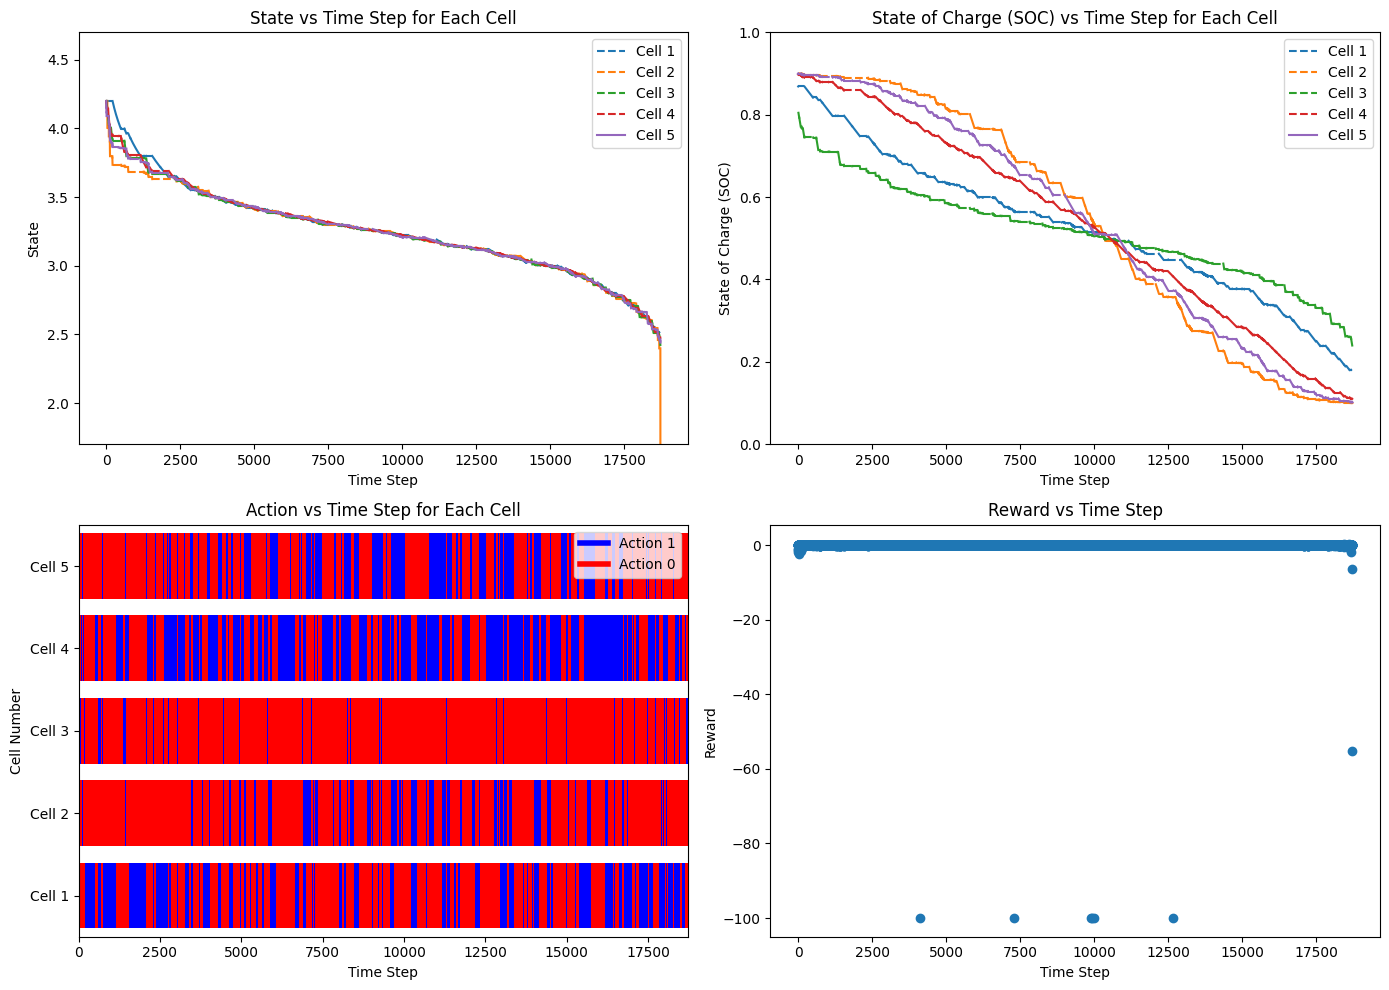

In [17]:
plot_bms_evolution(bms, states_6, states_soc_6, actions_6, rewards_6, dones_6, random_actions_6)

# DQN

In [18]:
bms.reset()
# Check if the environment follows the gym interface
check_env(bms)

In [19]:


model = DQN('MlpPolicy', bms, verbose=1, exploration_initial_eps= 0.01,
             exploration_final_eps=0.01, batch_size= 500, target_update_interval= 5_000, learning_rate= 0.0001)

# Train the model
# Note: Start with high epsilon for exploration and gradually reduce it for exploitation.
model.learn(total_timesteps= 250_000)

# Save the model
model.save("dqn_bms")

# Load the model
model = DQN.load("dqn_bms")

# Evaluate the model
bms.reset()
states_7 = [bms.state]
states_soc_7 = [bms.state_soc]
actions_7 = []
rewards_7 = []
dones_7 = [False]
actions_int_7 = []

while not dones_7[-1] and len(states_7) <  T:
    action, _ = model.predict(bms.state)
    actions_int_7.append(action)
    state_7, reward_7, done_7, _ , _= bms.step(action)
    states_7.append(state_7)
    states_soc_7.append(bms.state_soc)
    actions_7.append(bms.int_action_to_switch_action(action))
    rewards_7.append(reward_7)
    dones_7.append(done_7)

print(f"Sum of rewards: {np.sum(rewards_7)}")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 6.82e+03 |
|    ep_rew_mean      | -420     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 527      |
|    time_elapsed     | 51       |
|    total_timesteps  | 27293    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000245 |
|    n_updates        | 6798     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 8.21e+03 |
|    ep_rew_mean      | -378     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 521      |
|    time_elapsed     | 125      |
|    total_timesteps  | 65664    |
| train/              |        

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


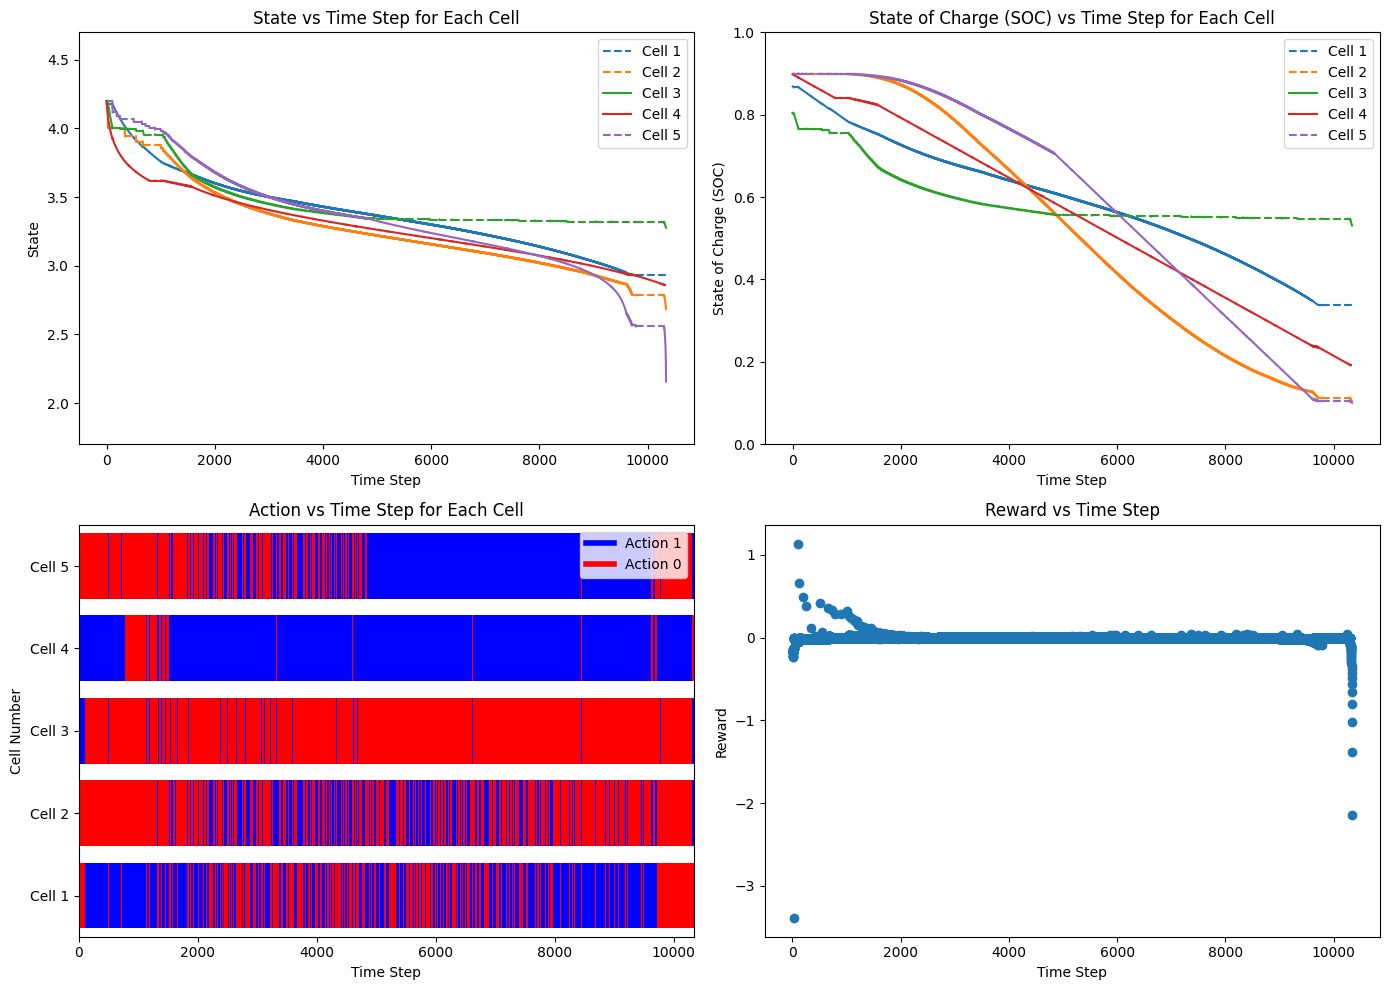

In [20]:
plot_bms_evolution(bms, states_7, states_soc_7, actions_7, rewards_7, dones_7)